Interactively figure out MGRS tiles and track numbers

In [35]:
import asf_search as asf
import geopandas as gpd
from shapely.geometry import box
from shapely.ops import unary_union
from shapely import force_2d
from rasterio.crs import CRS
import pandas as pd
import yaml
from pathlib import Path
from tqdm import tqdm
import rasterio
import numpy as np
from asf_search import ASFSession
import http.cookiejar
from dem_stitcher.geojson_io import read_geojson_gzip
import backoff
from skimage.restoration import denoise_tv_bregman
import matplotlib.pyplot as plt

# Load Event Data

In [50]:
yaml_file = 'events/monkey_creek_fire_2024.yml'
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'monkey_creek_fire_2024',
 'bounds': [-119.58304548, 44.80735, -118.969322, 45.0896335],
 'event_date': '2024-07-18',
 'pre_event_window_days': 100,
 'post_event_window_days': 60,
 'rtc_track_numbers': [5, 12],
 'mgrs_tiles': ['10TGQ', '11TLK'],
 'dist_hls_confirmed_change_min_days': 30,
 'links': ['https://data.usatoday.com/fires/monkey-creek/4c740d60-3ea2-40ae-9400-397a37d93a28/']}

# Read Geojson

<Axes: >

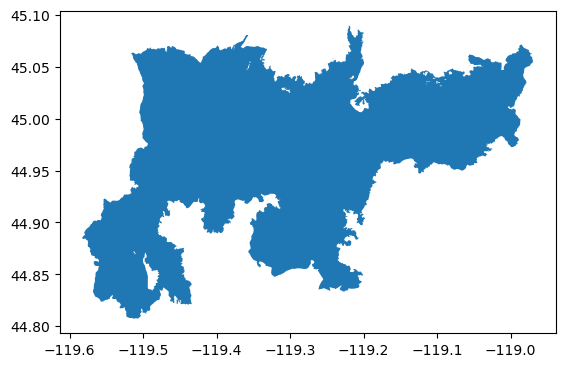

In [37]:
df_event = gpd.read_file(f'external_validation_data_db/{event_dict["event_name"]}.geojson')
df_event.plot()

In [38]:
df_event.head()

,name,date,source_id,geometry
0,monkey_creek_fire_2024,2024-08-04,WFIGS Monkey Creek,"MULTIPOLYGON (((-119.45575 44.82205, -119.4554..."


In [39]:
df_event.total_bounds

array([-119.58304548,   44.80735   , -118.969322  ,   45.0896335 ])

# Create Spatial AOI

In [40]:
aoi = box(*df_event.total_bounds)
df_aoi = gpd.GeoDataFrame(geometry=[aoi], crs=CRS.from_epsg(4326))

In [41]:
bounds = aoi.bounds
bounds

(-119.58304548199999, 44.80735, -118.969322, 45.08963350300007)

# Find MGRS tiles and Explore

In [42]:
df_mgrs = gpd.read_parquet('mgrs.parquet')
df_mgrs_overlapping = df_mgrs[df_mgrs.geometry.intersects(aoi)].reset_index(drop=True)
# remove antimeridian
df_mgrs_overlapping = df_mgrs_overlapping[~df_mgrs_overlapping.intersects(box(-180, -60, -179, 60))]
df_mgrs_overlapping.head()

,tile_id,epsg,utm_wkt,geometry
2,10TGQ,32610,"MULTIPOLYGON(((699960 5000040,699960 4890240,8...","MULTIPOLYGON (((-120.45737 45.12552, -120.5001..."
3,10TGR,32610,"MULTIPOLYGON(((699960 5100000,699960 4990200,8...","MULTIPOLYGON (((-120.41645 46.02437, -120.4612..."
4,11TLK,32611,"MULTIPOLYGON(((300000 5000040,300000 4890240,4...","MULTIPOLYGON (((-119.54314 45.12551, -119.5003..."
5,11TLL,32611,"MULTIPOLYGON(((300000 5100000,300000 4990200,4...","MULTIPOLYGON (((-119.58407 46.02435, -119.5392..."


In [43]:
m = df_mgrs_overlapping.explore(column='tile_id', categorical=True)
df_aoi.exterior.explore(m=m, style_kwds={'color':'black'})

# Select MGRS Tile(s)

In [51]:
MGRS_TILES = event_dict['mgrs_tiles']
MGRS_TILES

['10TGQ', '11TLK']

In [52]:
df_mgrs_search = df_mgrs_overlapping[df_mgrs_overlapping.tile_id.isin(MGRS_TILES)].reset_index(drop=True)
search_geo = df_mgrs_search.geometry.unary_union

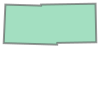

In [53]:
search_geo

# Explore Availability of RTC Data

In [54]:
import datetime
EVENT_DT = datetime.datetime.strptime(event_dict['event_date'], "%Y-%m-%d")
PRE_DT_START = EVENT_DT - datetime.timedelta(days=event_dict['pre_event_window_days'])
POST_DT_STOP = EVENT_DT + datetime.timedelta(days=event_dict['post_event_window_days'])


In [55]:
resp_pre = asf.geo_search(intersectsWith=search_geo.wkt,
                          processingLevel='RTC',
                          platform=asf.constants.SENTINEL1, 
                          start=PRE_DT_START, 
                          end=EVENT_DT)
len(resp_pre)

["'type': 'REVERSE': 'report': Reversed polygon winding order"]


521

In [56]:
resp_post = asf.geo_search(intersectsWith=search_geo.wkt,
                           processingLevel='RTC',
                           platform=asf.constants.SENTINEL1, 
                           start=EVENT_DT, 
                           end=POST_DT_STOP)
len(resp_post)

["'type': 'REVERSE': 'report': Reversed polygon winding order"]


142

In [61]:
df_rtc_resp_pre_e = gpd.GeoDataFrame.from_features(resp_pre.geojson(), crs=CRS.from_epsg(4326))
#df_rtc_resp_pre_e = df_rtc_resp_pre_e[df_rtc_resp_pre_e.pathNumber == 130].reset_index(drop=True)
df_rtc_resp_pre_e['geometry'] = df_rtc_resp_pre_e['geometry'].boundary
m = df_rtc_resp_pre_e.explore(alpha=.1, column='pathNumber', categorical=True, cmap='tab20c')
if MGRS_TILES is not None:
    df_mgrs_search.explore(m=m)
df_aoi.explore(m=m)
m

In [62]:
df_rtc_resp_pre_e.pathNumber.unique()

array([115,  64,  42, 144, 137])

In [63]:
df_rtc_resp_post_e = gpd.GeoDataFrame.from_features(resp_post.geojson(), crs=CRS.from_epsg(4326))
#df_rtc_resp_post_e = df_rtc_resp_post_e[df_rtc_resp_post_e.pathNumber == 130].reset_index(drop=True)
m = df_rtc_resp_post_e.explore()
if MGRS_TILES is not None:
    df_mgrs_search.explore(m=m)

In [64]:
df_rtc_resp_post_e.head()

,geometry,centerLat,centerLon,stopTime,fileID,flightDirection,pathNumber,processingLevel,url,startTime,...,validityStartDate,subswath,fileName,beamModeType,s3Urls,beamMode,additionalUrls,bistaticDelayCorrection,noiseCorrection,postProcessingFilter
0,"POLYGON ((-118.12009 44.06222, -119.14496 44.1...",44.038871,-118.651434,2024-08-11T13:58:29Z,OPERA_L2_RTC-S1_T144-307967-IW3_20240811T13582...,DESCENDING,144,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-08-11T13:58:26Z,...,None,IW3,OPERA_L2_RTC-S1_T144-307967-IW3_20240811T13582...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
1,"POLYGON ((-118.08305 44.22794, -119.10542 44.3...",44.204236,-118.613197,2024-08-11T13:58:27Z,OPERA_L2_RTC-S1_T144-307966-IW3_20240811T13582...,DESCENDING,144,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-08-11T13:58:23Z,...,None,IW3,OPERA_L2_RTC-S1_T144-307966-IW3_20240811T13582...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
2,"POLYGON ((-116.96474 44.14674, -118.14533 44.2...",44.137839,-117.574538,2024-08-11T13:58:26Z,OPERA_L2_RTC-S1_T144-307966-IW2_20240811T13582...,DESCENDING,144,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-08-11T13:58:22Z,...,None,IW2,OPERA_L2_RTC-S1_T144-307966-IW2_20240811T13582...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
3,"POLYGON ((-118.04333 44.39322, -119.07119 44.5...",44.369729,-118.575523,2024-08-11T13:58:24Z,OPERA_L2_RTC-S1_T144-307965-IW3_20240811T13582...,DESCENDING,144,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-08-11T13:58:21Z,...,None,IW3,OPERA_L2_RTC-S1_T144-307965-IW3_20240811T13582...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
4,"POLYGON ((-116.92473 44.31277, -118.10109 44.4...",44.303123,-117.533754,2024-08-11T13:58:23Z,OPERA_L2_RTC-S1_T144-307965-IW2_20240811T13582...,DESCENDING,144,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-08-11T13:58:20Z,...,None,IW2,OPERA_L2_RTC-S1_T144-307965-IW2_20240811T13582...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
